# Retrospective hotspotting

Recall that the "retrospective hotspot" method has no sense of time (but _often_ a sliding window of time is used, e.g. the last 8 weeks of data before the prediction date) and is a (normally grid based) KDE method.

In [1]:
%matplotlib inline
from common import *
datadir = os.path.join("//media", "disk", "Data")

In [2]:
south_side, points = load_data(datadir)

# Find the masked grid to use

It is definitely worth exploring how changing the offset of the grid affects prediction...

In [28]:
masked_grid = grid_for_south_side()
print("Total number of cells in region:", masked_grid.xextent * masked_grid.yextent)
print("Number of cells which intersect geometry:", np.sum(~masked_grid.mask))

Total number of cells in region: 2058
Number of cells which intersect geometry: 961


# Comparison between grid based and continuous

In [4]:
import open_cp.retrohotspot as retro

In [5]:
cts_pred = retro.RetroHotSpot()
cts_pred.data = points
cts_pred.weight = retro.Quartic(bandwidth = 1000)
cts_risk = cts_pred.predict(end_time = np.datetime64("2011-09-28"))
cts_grid_risk = open_cp.predictors.grid_prediction(cts_risk, masked_grid)

grid_pred = retro.RetroHotSpotGrid(grid=masked_grid)
grid_pred.data = points
grid_pred.weight = retro.Quartic(bandwidth = 1000)
grid_risk = grid_pred.predict(end_time = np.datetime64("2011-09-28"))
grid_risk.mask_with(masked_grid)

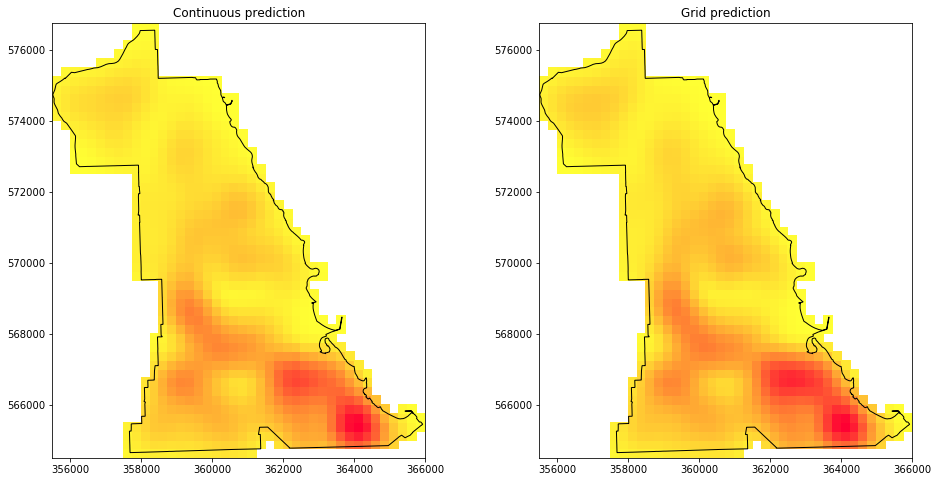

In [6]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.set_aspect(1)
    a.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    
ax[0].pcolormesh(*cts_grid_risk.mesh_data(), cts_grid_risk.intensity_matrix, cmap=yellow_to_red)
ax[0].set_title("Continuous prediction")
ax[1].pcolormesh(*grid_risk.mesh_data(), grid_risk.intensity_matrix, cmap=yellow_to_red)
ax[1].set_title("Grid prediction")
None

# Baseline hit rate

In [29]:
import open_cp.evaluation
import importlib
importlib.reload(open_cp.evaluation)

<module 'open_cp.evaluation' from '/nfs/see-fs-02_users/matmdpd/Crime Predict Project/PredictCode/open_cp/evaluation.py'>

In [30]:
class RetroHotSpot(open_cp.evaluation.PredictionProvider):
    def __init__(self, time_window_length = np.timedelta64(56, "D")):
        self.time_window_length = time_window_length
    
    def predict(self, time):
        grid_pred = retro.RetroHotSpotGrid(grid=masked_grid)
        grid_pred.data = points
        grid_pred.weight = retro.Quartic(bandwidth = 1000)
        grid_risk = grid_pred.predict(start_time = time - self.time_window_length, end_time = time)
        grid_risk.mask_with(masked_grid)
        return grid_risk

evaluator = open_cp.evaluation.HitRateEvaluator(RetroHotSpot())
evaluator.data = points
result = evaluator.run(time_range(), range(0,51))

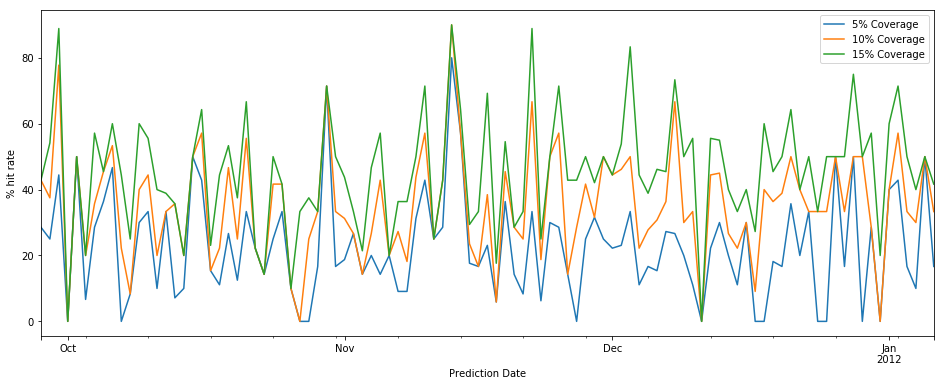

In [31]:
frame = to_dataframe(result.rates)

fig, ax = plt.subplots(figsize=(16,6))
(frame[5] * 100).plot(ax=ax)
(frame[10] * 100).plot(ax=ax)
(frame[15] * 100).plot(ax=ax)
ax.set_ylabel("% hit rate")
ax.legend(["{}% Coverage".format(x) for x in [5,10,15]])
None

In [32]:
frame.describe()

% Coverage,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
count,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,...,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.0,0.039240,0.078751,0.134663,0.184076,0.225609,0.269604,0.291598,0.313095,0.333508,...,0.807192,0.814921,0.827254,0.832258,0.839219,0.843034,0.848342,0.855938,0.864991,0.871453
std,0.0,0.068057,0.093700,0.115925,0.126788,0.158925,0.172838,0.166748,0.167284,0.168947,...,0.140486,0.132578,0.123392,0.121817,0.121937,0.121879,0.119548,0.118684,0.113671,0.109558
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.333333,0.333333,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
25%,0.0,0.000000,0.000000,0.000000,0.100000,0.111111,0.142857,0.176471,0.200000,0.222222,...,0.727273,0.733333,0.750000,0.789474,0.800000,0.800000,0.800000,0.800000,0.818182,0.823529
50%,0.0,0.000000,0.055556,0.125000,0.166667,0.200000,0.250000,0.285714,0.300000,0.333333,...,0.833333,0.833333,0.846154,0.850000,0.857143,0.857143,0.857143,0.875000,0.888889,0.888889
75%,0.0,0.066667,0.142857,0.187500,0.272727,0.312500,0.400000,0.400000,0.416667,0.437500,...,0.888889,0.888889,0.900000,0.900000,0.916667,0.916667,0.916667,0.923077,0.933333,0.933333
max,0.0,0.333333,0.333333,0.500000,0.500000,0.800000,0.900000,0.900000,0.900000,0.900000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


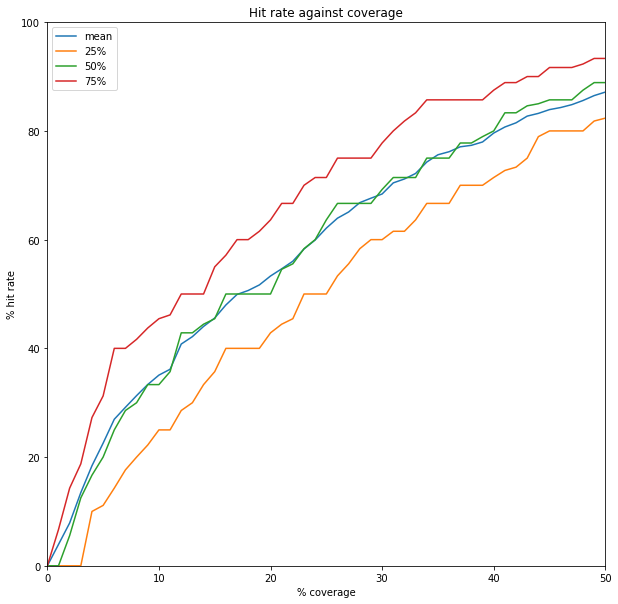

In [33]:
fig, ax = plt.subplots(figsize=(10,10))

d = frame.describe()
ax.plot(d.columns, d.ix["mean"]*100)
ax.plot(d.columns, d.ix["25%"]*100)
ax.plot(d.columns, d.ix["50%"]*100)
ax.plot(d.columns, d.ix["75%"]*100)
ax.legend()
ax.set(ylabel="% hit rate", xlabel="% coverage")
ax.set_title("Hit rate against coverage")
ax.set(xlim=[0,50], ylim=[0,100])
None

In [37]:
result.details[np.datetime64("2011-10-02")].prediction.intensity_matrix

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., 33.04184992874358 11.325850775641287 --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ..., False False  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = 1e+20)